# Model description

    S -> E -> I1 -> I2 -> I3 -> R 
    
### Transitions

we have $k = 3$ compartments of infected to get the quantile of the Ehrlang distribution right. We fix $R_0$ according to scenarios. Then 

- $S\longrightarrow E$ :       rate $\beta$ as $\beta = \frac{R_0 \cdot \gamma}{k}$  from $R_0$ 

- $E\longrightarrow I$ :       rate $\sigma = \frac{1}{5.2}$ d$^{-1}$

- $I_1\longrightarrow I_2$ :   rate $\gamma = \frac{1}{6} \cdot k$ d$^{-1}$

- $I_2\longrightarrow I_3$ :   rate $\gamma = \frac{1}{6} \cdot k$ d$^{-1}$

- $I_3\longrightarrow R$ :     rate $\gamma = \frac{1}{6} \cdot k$ d$^{-1}$

##### Approximated transitions:

- $p_{expose} =    1 - \exp(-\delta t \cdot \beta \cdot \frac{I_1 + I_2 + I_3}{H})$

- $p_{infect} =    1 - \exp(-\delta t \cdot \sigma)$

- $p_{recover} =   1 - \exp(-\delta t \cdot \gamma)$

and then draws in a binomial distribution, e.g $N_{I_1\longrightarrow I_2}(t) = \text{Binom}(I_1, 1 - \exp(-\delta t \cdot \gamma))$

In [3]:
def step_SEIR(t, y, p, uid): 
    """ 
    Slow, full python version of the SEIR model, hasn't been updated to three compartments.
    """
    p_expose =    1 - np.exp(-dt*p.beta[uid%nbetas]*(y[I1]+y[I2])/y[:-1].sum(axis=0))  # vector
    p_infect =    1 - np.exp(-dt*p.sigma) 
    p_recover =   1 - np.exp(-dt*p.gamma)
    
    exposeCases = np.random.binomial(y[S], p_expose)
    incidentCases = np.random.binomial(y[E], p_infect)
    incident2Cases = np.random.binomial(y[I1], p_recover)
    recoveredCases = np.random.binomial(y[I2], p_recover)

    return np.array([-exposeCases,                # dS
                exposeCases - incidentCases,      # dE
                incidentCases - incident2Cases,   # dI1
                incident2Cases - recoveredCases,  # dI2
                recoveredCases,                   # dR
                incidentCases])                   # dcumI



@jit(float64[:,:,:](float64[:,:], float64[:], int64), nopython=True)
def steps_SEIR_nb(y0, p_vec, uid): 
    """ 
        Made to run just-in-time-compiled by numba, hence very descriptive and using loop,
        because loops are expanded by the compiler hence not a problem.
        as there is very few authorized function. Needs the nopython option to be fast.
    """
    np.random.seed(uid)
    t = 0
    y = np.copy(y0)
    states = np.zeros((ncomp, nnodes, len(t_inter)))
    
    mv = np.empty(ncomp-1)
    exposeCases = np.empty(nnodes)
    incidentCases = np.empty(nnodes)
    incident2Cases = np.empty(nnodes)
    incident3Cases = np.empty(nnodes)
    recoveredCases = np.empty(nnodes)
    
    p_infect =    1 - np.exp(-dt*p_vec[1]) 
    p_recover =   1 - np.exp(-dt*p_vec[2])
    
    for it, t in enumerate(t_inter):
        for ori in range(nnodes):
            for dest in range(nnodes):
                for c in range(ncomp-1):
                    mv[c] = np.random.binomial(y[c,ori], 1 - np.exp(-dt*mobility[ori, dest]/popnodes[ori]))
                y[:-1,dest] += mv
                y[:-1,ori] -= mv

        p_expose =    1 - np.exp(-dt*p_vec[0]*(y[I1]+y[I2]+y[I3])/popnodes)  # vector


        for i in range(nnodes):
            exposeCases[i] =    np.random.binomial(y[S][i],  p_expose[i])
            incidentCases[i] =  np.random.binomial(y[E][i],  p_infect)
            incident2Cases[i] = np.random.binomial(y[I1][i], p_recover)
            incident3Cases[i] = np.random.binomial(y[I2][i], p_recover)
            recoveredCases[i] = np.random.binomial(y[I3][i], p_recover)
            
        y[S]    += -exposeCases
        y[E]    += exposeCases - incidentCases
        y[I1]   += incidentCases - incident2Cases
        y[I2]   += incident2Cases - incident3Cases
        y[I3]   += incident3Cases - recoveredCases
        y[R]    += recoveredCases
        y[cumI] += incidentCases
        states[:,:,it] = y
    
    return states


def run_SEIR(p, y0, uid):
    y = np.copy(y0).astype(np.int64)
    states = np.zeros((ncomp, nnodes, len(t_inter)))
    for i, t in enumerate(t_inter):
        for ori in range(nnodes):
            for dest in range(nnodes):
                mv = np.random.binomial(y[:-1,ori].astype(np.int), 1 - np.exp(-dt*mobility[ori, dest]/popnodes[ori])) # cumI does not move
                y[:-1,dest] += mv
                y[:-1,ori] -= mv
        y += step_SEIR(dt, y, p, uid)

        states[:,:,i] = y
    return states

def run_SEIR_nb(p, y0, uid):
    p_vec = p.to_vector(uid)
    states = steps_SEIR_nb(y0, p_vec, uid)
    return states
    
def run_par(p, y0):
    tic = time.time()
    uids = np.arange(nsim)
    with Pool(processes=16) as pool:
        result = pool.starmap(run_SEIR_nb, zip(itertools.repeat(p), itertools.repeat(y0), uids))
    print(f">>> {nsim}  Simulations done in {time.time()-tic} seconds...")
    return result

def run_par_noOVH(p, y0):
    tic = time.time()
    uids = np.arange(nsim)
    params = np.array([p.to_vector(uid) for uid in uids])
    with Pool(processes=16) as pool:
        result = pool.starmap(steps_SEIR_nb, zip( itertools.repeat(y0),params, uids))
    print(f">>> {nsim}  Simulations done in {time.time()-tic} seconds...")
    return result



def save_output_for_R(seir, name = 'none', folder='model_output/', write = True):
    """ 
    This is very ugly...
    """
    sims = []
    for s in range(nsim):
        a = seir[s].copy()[:,:,::int(1/dt)]
        a = np.moveaxis(a, 1, 2)
        a = np.moveaxis(a, 0, 1)
        b = np.diff(a,axis = 0)
        difI=np.zeros((t_span+1, nnodes))
        difI[1:,:] = b[:,cumI,:]
        na = np.zeros((t_span+1, ncomp+1, nnodes))
        na[:,:-1,:] = a
        na[:,-1,:] = difI
        
        m,n,r = na.shape
        out_arr = np.column_stack((np.tile(np.arange(n),m), na.reshape(n*m,-1)))

        out_df = pd.DataFrame(out_arr, columns = ['comp'] + list(spatial['name'].astype(int)),
                              index = pd.date_range(ti, tf, freq='D').repeat(ncomp+1))
        out_df['comp'].replace(S,     'S', inplace=True)
        out_df['comp'].replace(E,     'E', inplace=True)
        out_df['comp'].replace(I1,    'I1', inplace=True)
        out_df['comp'].replace(I2,    'I2', inplace=True)
        out_df['comp'].replace(I3,    'I3', inplace=True)
        out_df['comp'].replace(R,     'R', inplace=True)
        out_df['comp'].replace(cumI,  'cumI', inplace=True)
        out_df['comp'].replace(ncomp, 'diffI', inplace=True)
        if write: out_df.to_csv(f"{folder}sim_{s}_scn_{name}.csv", index='time', index_label='time')
        sims.append(out_df)
        
    return sims

In [4]:
tic = time.time()
steps_SEIR_nb(y0, p_mid.to_vector(0), 0)
print(f">>> Compilation done in {time.time()-tic} seconds...")

>>> Compilation done in 2.547360897064209 seconds...


In [7]:
#seir_low = run_par(p_low, y0)
#sims_low = save_output_for_R(seir_low, name='lowSF', write = True)
seir_mid = run_par_noOVH(p_mid, y0)

sims_mid = save_output_for_R(seir_mid, name='midnone', write = False)

>>> 100  Simulations done in 49.42830801010132 seconds...


In [111]:
class Results():
    def __init__(self, seir):
        freq = str(dt*24) + 'H'
        self.seir = seir
        # Build Quantiles:
        expand_data = [0]*nnodes

        for nd in range(nnodes):
            expand_data[nd] = {}
            expand_data[nd]['S'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            expand_data[nd]['E'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            expand_data[nd]['I1'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            expand_data[nd]['I2'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            expand_data[nd]['I3'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            expand_data[nd]['R'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            expand_data[nd]['cumI'] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                                    columns = np.arange(nsim))
            for sim in range(nsim):
                expand_data[nd]['S'][sim] =  seir[sim][S][nd]
                expand_data[nd]['E'][sim] =  seir[sim][E][nd]
                expand_data[nd]['I1'][sim] =  seir[sim][I1][nd]
                expand_data[nd]['I2'][sim] =  seir[sim][I2][nd]
                expand_data[nd]['I3'][sim] =  seir[sim][I2][nd]
                expand_data[nd]['R'][sim] =  seir[sim][R][nd]
                expand_data[nd]['cumI'][sim] = seir[sim][cumI][nd]
                        
        self.data  = expand_data
        
        self.colors = ['r', 'b', 'y', 'k', 'orange']
        self.figsize = (5,5)
        
    def plot_comp(self, comp, nodes):
        
        fig, axes = plt.subplots(1,1, figsize = self.figsize)

        for i,nd in enumerate(nodes):
            axes.plot(self.data[nd][comp].quantile(.5, axis = 1), c = self.colors[i%4])
            axes.fill_between(self.data[nd][comp].index, self.data[nd][comp].quantile(.05, axis = 1), 
                              self.data[nd][comp].quantile(.95, axis = 1), alpha =.3, 
                              facecolor = self.colors[i%4])
            
        axes.legend([spatial['name'][i] for i in range(nnodes)])
        fig.autofmt_xdate()
        
        return fig, axes


    def plot_all_comp(self, nodes):
        fig, axes = plt.subplots(2,4, figsize = (15,7))

        for c, comp in enumerate(['S', 'E', 'I1', 'I2', 'I3', 'R', 'cumI']):
            ax = axes.flat[c]
            ax.set_title(comp)
            for i, nd in enumerate(nodes):
                ax.plot(self.data[nd][comp].quantile(.5, axis = 1), c = self.colors[i%4])
                ax.fill_between(self.data[nd][comp].index, self.data[nd][comp].quantile(.05, axis = 1), 
                                  self.data[nd][comp].quantile(.95, axis = 1), alpha =.3, 
                                  facecolor = self.colors[i%4])
            
        ax.legend([spatial['name'][i] for i in nodes])
        fig.autofmt_xdate()
        return fig, axes
        
    def plot_comp_mult(self, comp, nodes):
        fig, axes = plt.subplots(len(nodes)//2,len(nodes)//2+1, figsize = (10,5), sharey = True, sharex =True)

        for i, nd in enumerate(nodes):
            ax = axes.flat[i]
            ax.set_title(spatial['name'][nd])
            ax.plot(self.data[nd][comp].quantile(.5, axis = 1), c = self.colors[i%4])
            ax.fill_between(self.data[nd][comp].index, self.data[nd][comp].quantile(.05, axis = 1), 
                                  self.data[nd][comp].quantile(.95, axis = 1), alpha =.3, 
                                  facecolor = self.colors[i%4])
            fig.autofmt_xdate()
        return fig, axes
            
results = Results(seir_mid)
#results_mid = Results(seir_mid)
#results_high = Results(seir_high)
nodes_to_plot = [int(spatial[spatial['name'] == 6067].id), int(spatial[spatial['name'] == 6075].id)]

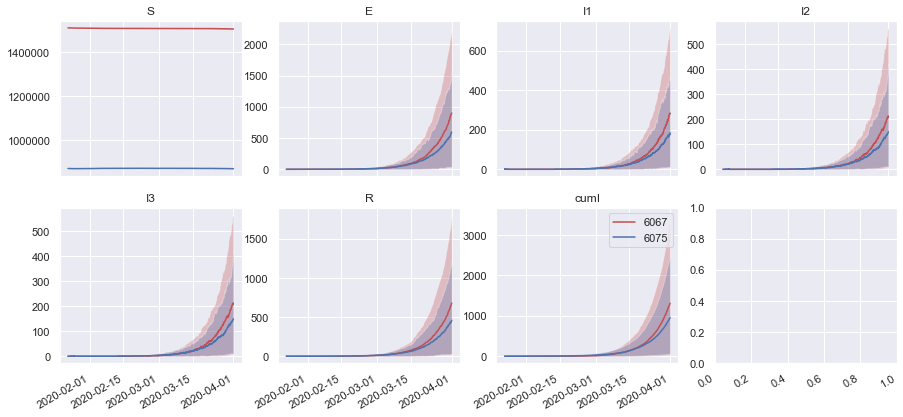

In [112]:
fig, axes = results.plot_all_comp(nodes_to_plot);
fig.autofmt_xdate()

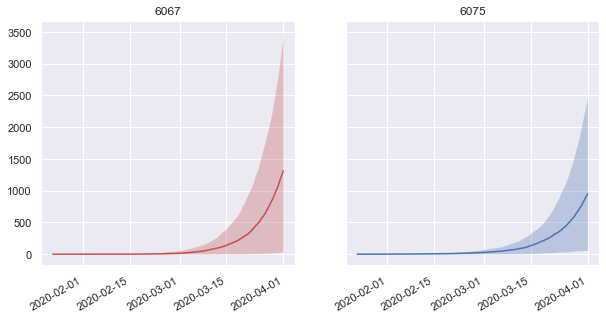

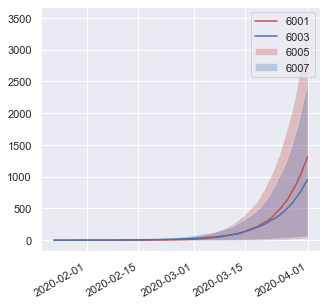

In [113]:
results.plot_comp_mult('cumI', nodes_to_plot);
fig, axes = results.plot_comp('cumI', nodes_to_plot)
#axes.set_ylim(0,20)

In [114]:
freq = str(dt*24) + 'H'
seir = seir_mid
# Build Quantiles:
expand_data = [0]*nnodes
comp = 'cumI'

for nd in range(nnodes):
    expand_data[nd] = {}
    expand_data[nd][comp] = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), 
                                            columns = np.arange(nsim))
    for sim in range(nsim):
        expand_data[nd][comp][sim] = seir[sim][cumI][nd]

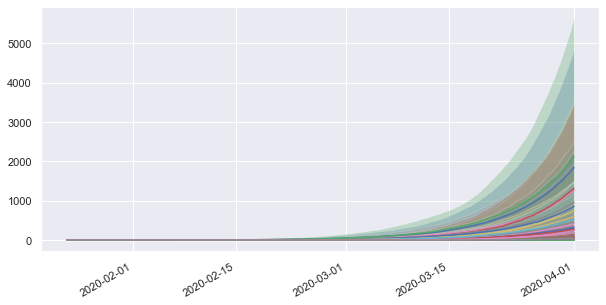

In [115]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharey = True, sharex =True)

for i, nd in enumerate(np.arange(nnodes)):
    ax.plot(expand_data[nd][comp].quantile(.5, axis = 1))
    ax.fill_between(expand_data[nd][comp].index, expand_data[nd][comp].quantile(.05, axis = 1), 
                          expand_data[nd][comp].quantile(.95, axis = 1), alpha =.3)
fig.autofmt_xdate()


In [116]:
q50 = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), columns = np.arange(nnodes))
q05 = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), columns = np.arange(nnodes))
q95 = pd.DataFrame(index = pd.date_range(ti, tf, freq = freq), columns = np.arange(nnodes))
for i, nd in enumerate(np.arange(nnodes)):
    q50[i] = expand_data[nd][comp].quantile(.5, axis = 1)
    q95[i] = expand_data[nd][comp].quantile(.95, axis = 1)
    q05[i] = expand_data[nd][comp].quantile(.05, axis = 1)

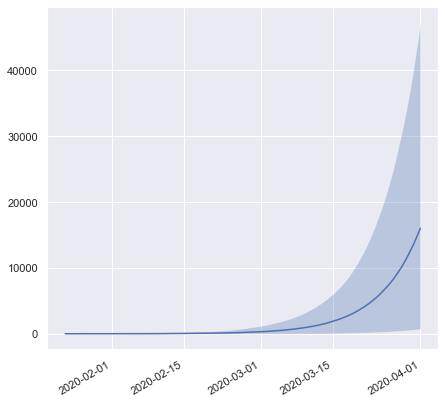

In [117]:
fig, ax = plt.subplots(1,1, figsize = (7,7), sharey = True, sharex =True)

ax.plot(q50.sum(axis=1))
ax.fill_between(q50.index, q05.sum(axis=1), q95.sum(axis=1), alpha =.3)
fig.autofmt_xdate()
#ax.set_ylim(0, 10)

### checks with doubling time

We are aiming for 8.2 days of serial interval

We have a mean $R_0 = 2.5$, and a serial interval of $1/2 (1/\gamma \cdot 1/k) + 1/\sigma = 3 + 5.2  = 8.2$. We have 69 days since seeding, giving 8.4 generation. That means that we have $n_{seed}\cdot 2.5^{8.4} = 3 \cdot 2'201 = 6'603$ infected at the end of simulation.

The actual serial interval from the `q50.sum(axis=1)[-1]` $?/3 = 5332$, number of generation (wolfram alpha, I'm tired stupid) $9.3$ days -> 10 days effective interval. 

Longer in actual sims. Is that because of stochastic dieout or mobility ? Let's try by disabling mobility:

The actual serial interval from the `q50.sum(axis=1)[-1]` $1'949/3 = 649$, number of generation (wolfram alpha, I'm tired stupid) $7$ days -> 9.8 days effective interval. No that much different.

In [119]:
q50.sum(axis=1)[-1]/3

5332.166666666667

In [120]:
69/9.3

7.419354838709677

### Determinitic model for check

In [ ]:
def dy(t,y, p_vec, nd):
    dy = np.zeros_like(y)
    dy[S] = -p_vec[0] * (y[I1]+y[I2]) / popnodes[nd]
    dy[E] = p_vec[0] * (y[I1]+y[I2]) / popnodes[nd] - p_vec[1]*y[E]
    dy[I1] = p_vec[1]*y[E] - p_vec[2]*y[I1]
    dy[I2] = p_vec[2]*y[I1] - p_vec[2]*y[I2]
    dy[R] =  p_vec[2]*y[I2]
    dy[cumI] = p_vec[1]*y[E]
    return dy
    
sol = scipy.integrate.solve_ivp(lambda t,y: dy(t, y,
                                                p_vec = p_mid.to_vector(0),
                                                nd = spatial[spatial['name'] == seedplace].id), 
                                 t_span=(0, t_span+1),
                                 y0 = np.squeeze(y0[:, spatial[spatial['name'] == seedplace].id]),
                                 t_eval = np.arange(t_span+1))
sim = sims_mid[0]
plt.plot(sim[sim['comp'] == 'cumI'].index, sol.y[cumI])

# Deprecated below

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10,5), sharey=True)

for sim in sims_mid[:-500]:
    axes.plot(sim[sim['comp'] == 'cumI'].sum(axis=1))

axes.set_ylim(0,1e6)
axes.set_title(f"dt = {dt*24} H");

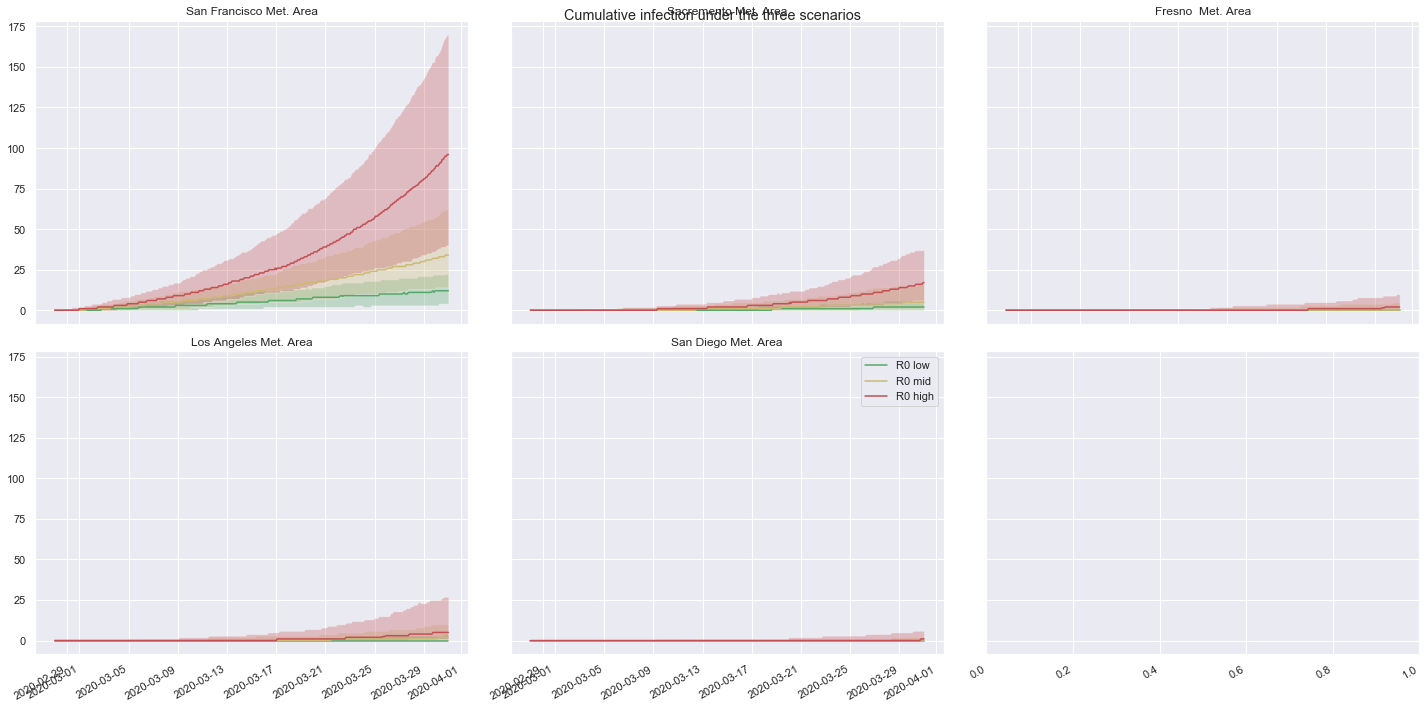

In [57]:
fig, axes = plt.subplots(nnodes//2,nnodes//2+1, figsize = (20,10), sharey=True)
comp = 'Ic'

for nd in range(nnodes):
    ax = axes.flat[nd]
    ax.set_title(spatial['name'][nd])
    ax.plot(results_low.data[nd][comp].quantile(.5, axis = 1), color = 'g')
    ax.fill_between(results_low.data[nd][comp].index, results_low.data[nd][comp].quantile(.05, axis = 1), 
                                  results_low.data[nd][comp].quantile(.95, axis = 1), alpha =.3, facecolor = 'g')
    ax.plot(results_mid.data[nd][comp].quantile(.5, axis = 1), color = 'y')
    ax.fill_between(results_mid.data[nd][comp].index, results_mid.data[nd][comp].quantile(.05, axis = 1), 
                                  results_mid.data[nd][comp].quantile(.95, axis = 1), alpha =.3, facecolor ='y')
    ax.plot(results_high.data[nd][comp].quantile(.5, axis = 1), color = 'r')
    ax.fill_between(results_high.data[nd][comp].index, results_high.data[nd][comp].quantile(.05, axis = 1), 
                                 results_high.data[nd][comp].quantile(.95, axis = 1), alpha =.3, facecolor = 'r')

ax.legend(['R0 low', 'R0 mid', 'R0 high']);
fig.suptitle('Cumulative infection under the three scenarios');
fig.autofmt_xdate()
fig.tight_layout()

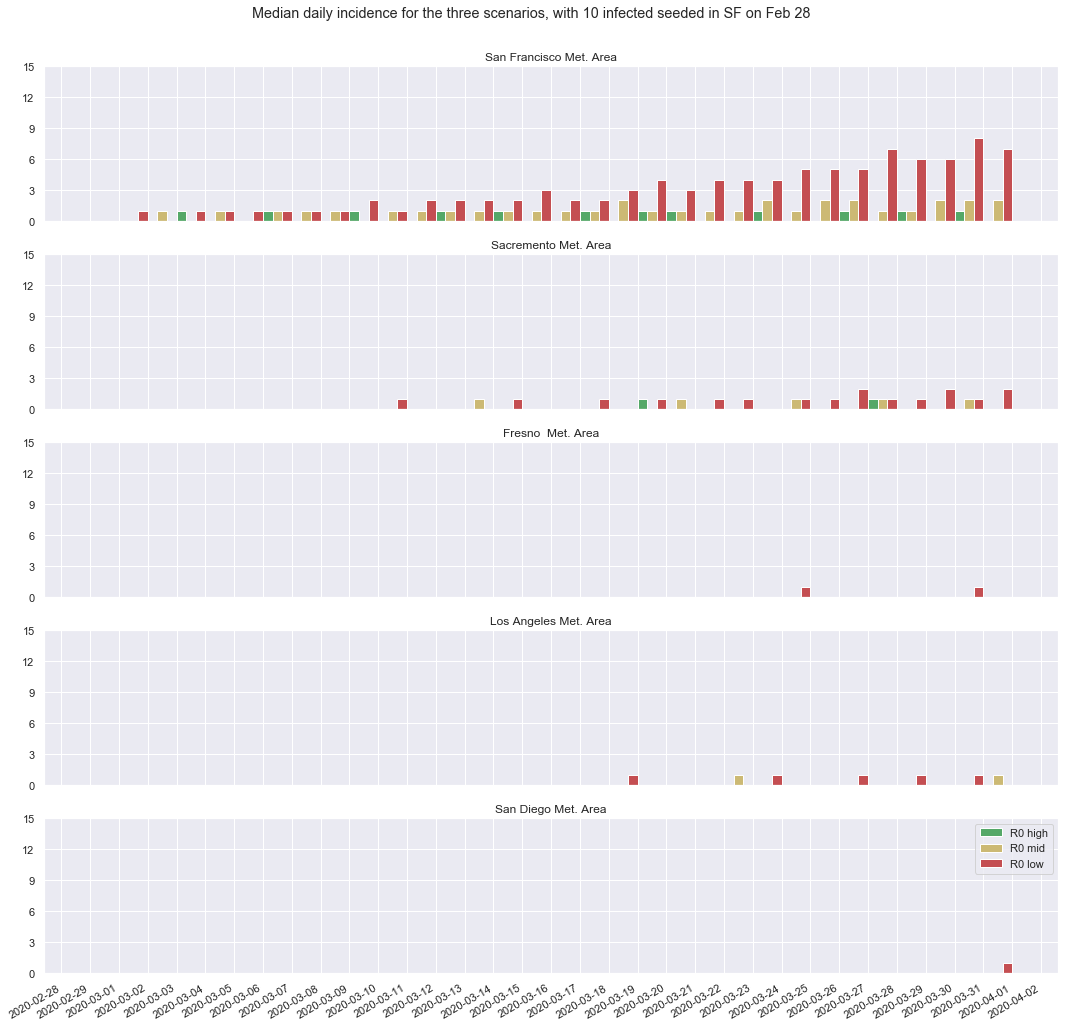

In [90]:
import matplotlib.dates as mdates
fig, axes = plt.subplots(nnodes//1,1, figsize = (15,15), sharey = True)
comp = 'Ic'
sampling = 'D'  #'W-SAT'
width = .333334

for nd in range(nnodes):
    ax = axes.flat[nd]
    ax.set_title(spatial['name'][nd])
    ax.bar(results_low.data[nd][comp].resample(sampling).asfreq().index, 
           results_low.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff(),
           width = width, facecolor = 'g', alpha = 1, align='edge')#,
          # yerr = (results_low.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff() - \
          #         results_low.data[nd][comp].quantile(.05, axis = 1).resample(sampling).asfreq().diff(),
          #         results_low.data[nd][comp].quantile(.95, axis = 1).resample(sampling).asfreq().diff() - \
          #         results_low.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff()))
   
    ax.bar(results_low.data[nd][comp].resample(sampling).asfreq().index+datetime.timedelta(days=1/3), 
           results_mid.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff(),
           width = width, facecolor = 'y', alpha = 1, align='edge')#,
           #yerr = (
           #        results_mid.data[nd][comp].quantile(.05, axis = 1).resample(sampling).asfreq().diff(),
           #        results_mid.data[nd][comp].quantile(.95, axis = 1).resample(sampling).asfreq().diff() ))
    
    ax.bar(results_low.data[nd][comp].resample(sampling).asfreq().index+datetime.timedelta(2/3), 
           results_high.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff(),
           width = width, facecolor = 'r', alpha = 1, align='edge')#,
          # yerr = (results_high.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff() - \
          #         results_high.data[nd][comp].quantile(.05, axis = 1).resample(sampling).asfreq().diff(),
          #         results_high.data[nd][comp].quantile(.95, axis = 1).resample(sampling).asfreq().diff() - \
          #         results_high.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq().diff()))

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.set_yticks(np.arange(0,20,3))
    ax.set_ylim(0,15)

ax.legend(['R0 low','R0 mid', 'R0 high']);
fig.suptitle('Median daily incidence for the three scenarios, with 10 infected seeded in SF on Feb 28');
fig.autofmt_xdate()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [86]:
import matplotlib.dates as mdates
fig, axes = plt.subplots(nnodes//1,1, figsize = (10,15), sharey = True)
comp = 'Ic'
sampling = 'D'  #'W-SAT'
width = .333334

for nd in range(nnodes):
    ax = axes.flat[nd]
    ax.set_title(spatial['name'][nd])
    ax.bar(results_low.data[nd][comp].resample(sampling).asfreq().index, 
           results_low.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq(),
           width = width, facecolor = 'g', alpha = 1, align='edge',
           yerr = (results_low.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq() - \
                   results_low.data[nd][comp].quantile(.05, axis = 1).resample(sampling).asfreq(),
                   results_low.data[nd][comp].quantile(.95, axis = 1).resample(sampling).asfreq() - \
                   results_low.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq()))
   
    ax.bar(results_low.data[nd][comp].resample(sampling).asfreq().index+datetime.timedelta(days=1/3), 
           results_mid.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq(),
           width = width, facecolor = 'y', alpha = 1, align='edge',
            yerr = (results_mid.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq() - \
                   results_mid.data[nd][comp].quantile(.05, axis = 1).resample(sampling).asfreq(),
                   results_mid.data[nd][comp].quantile(.95, axis = 1).resample(sampling).asfreq() - \
                   results_mid.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq()))
    
    ax.bar(results_low.data[nd][comp].resample(sampling).asfreq().index+datetime.timedelta(2/3), 
           results_high.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq(),
           width = width, facecolor = 'r', alpha = 1, align='edge',
           yerr = (results_high.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq() - \
                   results_high.data[nd][comp].quantile(.05, axis = 1).resample(sampling).asfreq(),
                   results_high.data[nd][comp].quantile(.95, axis = 1).resample(sampling).asfreq() - \
                   results_high.data[nd][comp].quantile(.5, axis = 1).resample(sampling).asfreq()))

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.set_yticks(np.arange(0,210,30))
    ax.set_ylim(0,180)

ax.legend(['R0 low','R0 mid', 'R0 high']);
fig.suptitle('Median cumulative for the three scenarios, with 10 infected seeded in SF on Feb 28');
fig.autofmt_xdate()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

IndentationError: unexpected indent (<ipython-input-86-952366aff554>, line 36)

# For Large sim

In [178]:
# I need to collapse a dimension: tempora or number of sim ? Let's take number of sims
freq = str(int(dt*24)) + 'H'


expand_data = np.zeros((nsim, nnodes,   int(t_span/dt+1)))

for s in range(nsim):
    expand_data[s] = seir_mid[s][cumI]
    
data = pd.DataFrame(np.percentile(expand_data, 0.95, axis= 0).T,
                       index = pd.date_range(start  = ti, end = tf, freq = freq),
                       columns = spatial['name'].astype(int))  

data_fixed = data.sum(axis = 0)
data_fixed  = pd.DataFrame(data_fixed, columns=['Incidence'], index = spatial['name'].astype(int), )

In [68]:
import geopandas as gpd
import geoplot

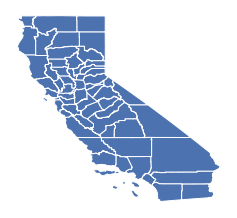

In [69]:
counties_shp = gpd.read_file('california-data-county/california-counties-shp/california-counties.shp')
counties_shp.sort_values('GEOID', inplace=True)
fig, ax = plt.subplots(1, figsize=(4,4))
counties_shp.plot(ax = ax)
ax.set_axis_off()

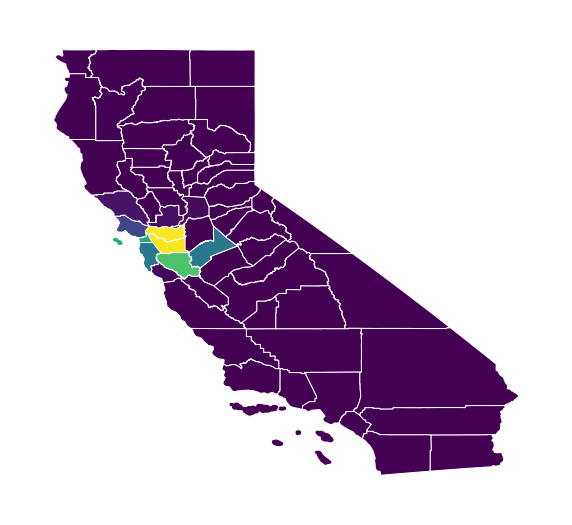

In [84]:
geoplot.choropleth(counties_shp, hue=data_fixed['Incidence'].array, cmap='viridis', figsize=(10, 10))